In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd

# Load Dataset 

In [8]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full.parquet')
dataset.drop(columns=['lon', 'lat'], inplace=True, errors='ignore')
print("=== Dataset Types :\n", dataset.dtypes)

dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])

print("=== Null Values :\n", dataset.isnull().sum())

X = dataset.drop('fire', axis=1)
X_numeric_columns = X.select_dtypes(include=['number']).columns
X[X_numeric_columns] = StandardScaler().fit_transform(X[X_numeric_columns])
X = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns)

Y = dataset[['fire']]

print("=== X columns:", X.columns)
print("=== Y index:", Y.index)

X_train, X_test, Y_train, Y_test = train_test_split(
    X.to_numpy(), Y.to_numpy(),
    test_size=0.2,      # 20% test
    random_state=42,    # for reproducibility
    shuffle=True        # default True
)

=== Dataset Types :
 fire                        int64
log_precip_s1             float64
log_precip_s2             float64
log_precip_s3             float64
log_precip_s4             float64
tmax_s1                   float64
tmax_s2                   float64
tmax_s3                   float64
tmax_s4                   float64
amplitude_thermique_s1    float64
amplitude_thermique_s2    float64
amplitude_thermique_s3    float64
amplitude_thermique_s4    float64
GRIDCODE                  float64
log_area_sqm              float64
lcc_code_encoded          float64
elevation                 float32
COARSE                    float64
SAND                      float64
SILT                      float64
CLAY                      float64
TEXTURE_USDA              float64
TEXTURE_SOTER              object
BULK                      float64
REF_BULK                  float64
ORG_CARBON                float64
PH_WATER                  float64
TOTAL_N                   float64
CN_RATIO                  f

# SKlearn Model Training

In [9]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

knn.fit(X_train, Y_train)


f:\Programming\Languages\Python310\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,-1


# Scratch Model Training

In [10]:

import numpy as np
from collections import Counter

class FastKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _euclidean_distances(self, X):
        """
        Vectorized distance computation:
        Computes distances from many samples X to all training samples.
        Uses (a - b)^2 = a^2 + b^2 - 2ab trick.
        """

        # X: (n_test, n_features)
        # X_train: (n_train, n_features)

        X_square = np.sum(X**2, axis=1).reshape(-1, 1)          # (n_test, 1)
        train_square = np.sum(self.X_train**2, axis=1)          # (n_train,)
        cross = X @ self.X_train.T                               # (n_test, n_train)

        # squared distances (no sqrt needed)
        dists = X_square + train_square - 2 * cross
        return dists

    def predict(self, X):
        # Compute all distances in one shot
        dists = self._euclidean_distances(X)

        # Indices of k nearest neighbors per test sample
        k_indices = np.argpartition(dists, self.k, axis=1)[:, :self.k]

        # Convert labels
        k_labels = self.y_train[k_indices]

        # Majority vote across axis 1
        preds = np.array([Counter(row).most_common(1)[0][0] for row in k_labels])
        return preds



knn_scratch = FastKNN(k=5)
knn_scratch.fit(X_train, Y_train)

# SKlearn Model Testing

Accuracy : 0.8925824857355495
Precision: 0.7981252092400402
Recall   : 0.7740259740259741
F1 Score : 0.7858908851162024


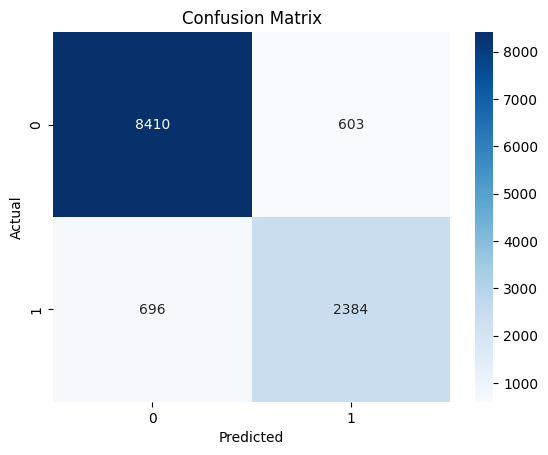

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      9013
           1       0.80      0.77      0.79      3080

    accuracy                           0.89     12093
   macro avg       0.86      0.85      0.86     12093
weighted avg       0.89      0.89      0.89     12093



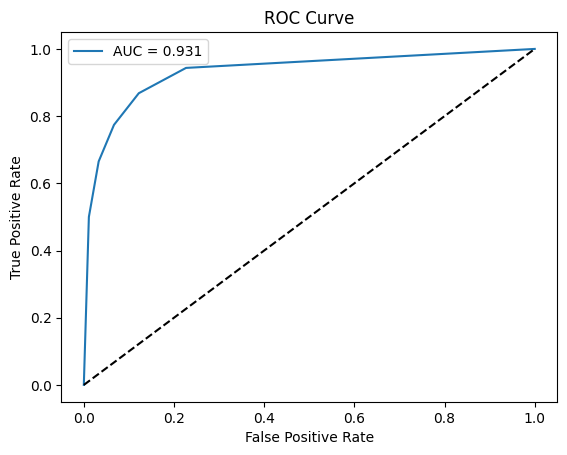

In [ ]:
probs = knn.predict_proba(X_test)
preds = probs.argmax(axis=1)

print("Accuracy :", accuracy_score(Y_test, preds))
print("Precision:", precision_score(Y_test, preds, average='binary'))
print("Recall   :", recall_score(Y_test, preds, average='binary'))
print("F1 Score :", f1_score(Y_test, preds, average='binary'))

cm = confusion_matrix(Y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(Y_test, preds))


fpr, tpr, _ = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Scratch Model Testing

In [12]:
# predictions = knn_scratch.predict(X_test)
# accuracy = (predictions == Y_test).mean() 
# print(f'Scratch KNN Model Accuracy: {accuracy * 100:.2f}%')